100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


(2, 100)


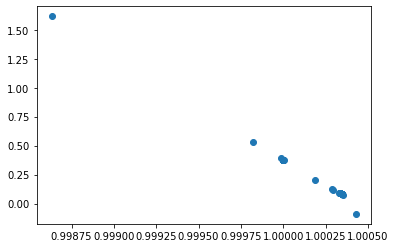

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize
import tfim
import tfim_perturbation

# Initial system specification
L = [3]
Jij_seed = 19
h_x_range = np.arange(0, 0.001, 0.00002)

PBC = True
J = 1

# Build lattice and basis
###################################
lattice = tfim.Lattice(L, PBC)
N = lattice.N
basis = tfim.IsingBasis(lattice)
###################################

#construct random J matrix
Jij = tfim.Jij_instance(N,J,"bimodal",Jij_seed)

# List out all the spin_states, corresponding indices and energies
Energies = -tfim.JZZ_SK_ME(basis,Jij)
# for index in range(2**N):
#     print(index, basis.state(index), Energies[index])

#construct random J matrix
Jij = tfim.Jij_instance(N,J,"bimodal",Jij_seed)

# Build 2nd order approximated matrix

GS_energy, GS_indices = tfim_perturbation.GS(Energies)

H_app_0 = tfim_perturbation.H_app_0(GS_energy, GS_indices)

H_app_1 = tfim_perturbation.H_app_1(basis, GS_indices, N)

# Parametrize H_app_2

def H_app_2(basis, Jij, GS_indices, N, GS_energy):
    # Second-Order term in perturbation theory
    H_app_2 = np.zeros((len(GS_indices), len(GS_indices)))

    for column, GS_ket_1 in enumerate(GS_indices):
        state_1 = basis.state(GS_ket_1)
        for i in range(N):
            basis.flip(state_1, i)
            state_1_flipped_index = basis.index(state_1)
            if state_1_flipped_index not in GS_indices:
                energy_gap = tfim_perturbation.state_energy(basis, Jij, state_1_flipped_index) - GS_energy
                for j in range(N):
                    basis.flip(state_1, j)
                    ES_2_flipped_index = basis.index(state_1)
                    GS_2_index = np.argwhere(np.array(GS_indices) == ES_2_flipped_index)
                    if len(GS_2_index) > 0:
                        row = GS_2_index[0][0]
                        H_app_2[row, column] -= 1. / energy_gap
                    basis.flip(state_1, j)
            basis.flip(state_1, i)
    return H_app_2

# 2nd order term

H_app_2 = H_app_2(basis, Jij, GS_indices, N, GS_energy)

# Build exact matrix
V_exc = tfim_perturbation.V_exact(basis, lattice)
H_0_exc = tfim_perturbation.H_0_exact(Energies)

# Build H_app_2nd

def H_app_2_param(h_x, param):
    return H_app_0 + h_x*H_app_1 + np.power(h_x, 2.)*param*H_app_2

# Define error function to be minimized
def err(x):
    param = x[0]
    alpha = x[1]
    # alpha is the fitting parameter for the 3rd order polynomial
    error_arr = np.zeros(np.shape(h_x_range))
    for i, h_x in enumerate(h_x_range):
        H_app = H_app_2_param(h_x, param)
        # Calculate the energy eigenvalue of the approximated 2nd order matrix
        app_eigenvalues, app_eigenstates = eigh(H_app)
        # print(app_eigenvalues)
        app_GS_eigenvalue = min(app_eigenvalues)
        # Calculate exact eigenvalues and eigenstates for range(h_x)
        exc_eigenvalues, exc_eigenstates = tfim_perturbation.exc_eigensystem(basis, h_x_range, lattice, Energies)
        # print(exc_eigenvalues)
        exc_GS_eigenvalue = min(exc_eigenvalues[:,i])
        error_arr[i] = abs(abs(app_GS_eigenvalue-exc_GS_eigenvalue) - alpha*np.power(h_x, 3.))
    # print(error_arr)
    return np.sqrt(sum(np.power(error_arr, 2.)))

# # Perform optimization
# x_0 = [100., 100.]
# res = minimize(err, x_0, method = 'Nelder-Mead')
# # print("optimized perturbation parameter: ", res.x[0], "optimized curve fitting parameter: ", res.x[1])
# print(res.x)

# # Fixed alpha and plot error function
# length = 100
# x_arr = np.zeros((length,2))
# x_arr[:,0] = np.linspace(-1., 1., length)
# x_arr[:,1] = 0.37*np.ones(length)
# err_arr = np.zeros(np.shape(x_arr[:,0]))
# for i in range(len(x_arr[:, 0])):
#     err_arr[i] = err(x_arr[i, 0])
# fig = pl.figure(figsize=(8, 6))
# pl.rcParams['font.size'] = '18'
# pl.plot(x_arr[:,0],err_arr/len(err_arr), lw=1.3, ls='-', color="blue")
# pl.ylabel(r'$Error$', fontsize=18)
# pl.xlabel('Coefficient for 2nd order', fontsize=18)
# pl.xticks(fontsize=18)
# pl.yticks(fontsize=18)
# pl.tick_params('both', length=7, width=2, which='major')
# pl.tick_params('both', length=5, width=2, which='minor')
# pl.grid(True)
# pl.legend(loc=2, prop={'size': 16}, numpoints=1, scatterpoints=1, ncol=2)
# fig.tight_layout(pad=0.5)
# pl.savefig("Error_plot.png")

# Contour plot
coeff_arr = np.linspace(-0.5, 1.5, 10)
alpha_arr = np.linspace(-1., 1., 10)
err_scatter = np.array([[0,0]])
for i, coeff in enumerate(coeff_arr):
    for j, alpha in enumerate(alpha_arr):
        # err_matrix[i, j] = err([coeff, alpha])
        x_0 = [coeff, alpha]
        res = minimize(err, x_0, method = 'Nelder-Mead')
        err_scatter = np.concatenate((err_scatter, [res.x]), axis = 0)
err_scatter = np.transpose(err_scatter[1:])
print(np.shape(err_scatter))
plt.scatter(err_scatter[0], err_scatter[1])

In [14]:
# Contour plot
coeff_arr = np.linspace(-0.5, 1.5, 10)
alpha_arr = np.linspace(-1., 1., 10)
X, Y = np.meshgrid(coeff_arr, alpha_arr)
err_matrix = np.zeros((len(coeff_arr), len(alpha_arr)))
for i, coeff in enumerate(coeff_arr):
    for j, alpha in enumerate(alpha_arr):
        err_matrix[i, j] = err([coeff, alpha])

print(err_matrix)
# fig, ax = plt.subplots()
# CS = ax.contourf(X, Y, err_matrix, cmap = 'hot')
# fig.set_size_inches(8, 6)
# ax.clabel(CS, inline = True, fontsize=10)
# fig.show()

[[3.47219644e-06 3.47163125e-06 3.47106606e-06 3.47050088e-06
  3.46993570e-06 3.46937052e-06 3.46880535e-06 3.46824017e-06
  3.46767500e-06 3.46710984e-06]
 [2.95831507e-06 2.95774988e-06 2.95718469e-06 2.95661951e-06
  2.95605433e-06 2.95548915e-06 2.95492397e-06 2.95435880e-06
  2.95379363e-06 2.95322846e-06]
 [2.44443371e-06 2.44386852e-06 2.44330332e-06 2.44273814e-06
  2.44217295e-06 2.44160777e-06 2.44104260e-06 2.44047743e-06
  2.43991226e-06 2.43934709e-06]
 [1.93055235e-06 1.92998715e-06 1.92942196e-06 1.92885677e-06
  1.92829158e-06 1.92772640e-06 1.92716122e-06 1.92659605e-06
  1.92603088e-06 1.92546572e-06]
 [1.41667101e-06 1.41610580e-06 1.41554060e-06 1.41497540e-06
  1.41441021e-06 1.41384503e-06 1.41327985e-06 1.41271468e-06
  1.41214951e-06 1.41158436e-06]
 [9.02789709e-07 9.02224478e-07 9.01659258e-07 9.01094047e-07
  9.00528847e-07 8.99963656e-07 8.99398476e-07 8.98833306e-07
  8.98268145e-07 8.97702996e-07]
 [3.88908591e-07 3.88343284e-07 3.87778001e-07 3.87212741e